In [11]:
import torch
import torch.nn as nn
import torchvision.models as models

import glob
import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import time
from tqdm import tqdm
import copy
from IPython.display import display, Image, clear_output

import tqdm

In [4]:
cd AdversarialRendering/

/home/dcor/niskhizov/AdversarialRendering


In [55]:
import pickle
dump_dir = './dump_for_train/'
with open(dump_dir + 'decoded_latent.pickle','rb') as f:
    decoded_latent = pickle.load(f)
with open(dump_dir + 'unwrapped_frames.pickle','rb') as f:
    unwrapped_frames = pickle.load(f)

with open(dump_dir + 'orig_ref_frame.pickle','rb') as f:
    orig_ref_frame = pickle.load(f)

with open(dump_dir + 'H.pickle','rb') as f:
    H = pickle.load(f)

In [41]:
    

class LightSkipCNN(nn.Module):
    def __init__(self, in_channels=3):
        super(LightSkipCNN, self).__init__()

        # Encoder
        self.enc1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        
        self.enc2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # Decoder
        self.dec1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.dec2 = nn.Conv2d(16, in_channels, kernel_size=3, padding=1)

        # Swish (SiLU) Activation to Avoid Vanishing Gradients
        self.activation = nn.SiLU()  # Swish = x * sigmoid(x)

    def forward(self, x):
        # Encoder
        x1 = self.activation(self.enc1(x))  # First conv
        x2 = self.activation(self.enc2(x1)) # Second conv

        # Decoder + Skip Connections
        x3 = self.activation(self.dec1(x2)) + x1  # Skip from enc1
        x4 = self.dec2(x3)  # Skip from input

        return x4  # Output has same shape as input


class LightCNN(nn.Module):
    def __init__(self):
        super(LightCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7, padding=3),  # 4x60x80 -> 8x60x80
            nn.ELU(),
            nn.Conv2d(8, 16, kernel_size=5, padding=2), # 8x60x80 -> 16x60x80
            nn.ELU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1), # 16x60x80 -> 8x60x80
            nn.ELU(),
            nn.Conv2d(8, 3, kernel_size=3, padding=1) )  # 8x60x80 -> 4x60x80
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

mapper = LightSkipCNN().cuda()#LightCNN().cuda()

In [42]:
l_train = decoded_latent[:90]
f_train = unwrapped_frames[:90]

l_test = decoded_latent[90:]
f_test = unwrapped_frames[90:]

In [43]:
train_loader = torch.utils.data.DataLoader(list(zip(l_train, f_train)), batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(l_test, f_test)), batch_size=16, shuffle=False)
mapper_opt = torch.optim.Adam(mapper.parameters(), lr=0.001)
mapper.train()

LightSkipCNN(
  (enc1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec2): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation): SiLU()
)

In [44]:
L1 = nn.L1Loss()
for epoch in tqdm.tqdm(range(1000)):
    for i, (s, f) in enumerate(train_loader):
        s = s.cuda().float()
        f = f.cuda().float()
        mapper_opt.zero_grad()
        pred = mapper(s.squeeze(1))
        loss = L1(pred, f.squeeze(1))
        loss.backward()
        mapper_opt.step()
    test_loss = 0
    if epoch % 10 == 0:
        for i, (s, f) in enumerate(test_loader):
            s_test = s.cuda().float()
            f_test = f.cuda().float()
            mapper_opt.zero_grad()
            pred_test = mapper(s_test.squeeze(1))
            loss = L1(pred_test, f_test.squeeze(1))
            test_loss += loss.item()
        test_loss /= len(test_loader)
        print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}")
        



  0%|          | 1/1000 [00:00<08:31,  1.95it/s]

Epoch 1, Test Loss: 0.4495


  1%|          | 11/1000 [00:05<07:49,  2.11it/s]

Epoch 11, Test Loss: 0.0912


  2%|▏         | 21/1000 [00:09<07:43,  2.11it/s]

Epoch 21, Test Loss: 0.0886


  3%|▎         | 31/1000 [00:14<07:38,  2.11it/s]

Epoch 31, Test Loss: 0.0880


  4%|▍         | 41/1000 [00:18<07:33,  2.11it/s]

Epoch 41, Test Loss: 0.0865


  5%|▌         | 51/1000 [00:23<07:30,  2.11it/s]

Epoch 51, Test Loss: 0.0869


  6%|▌         | 61/1000 [00:28<07:25,  2.11it/s]

Epoch 61, Test Loss: 0.0824


  7%|▋         | 71/1000 [00:32<07:21,  2.11it/s]

Epoch 71, Test Loss: 0.0807


  8%|▊         | 81/1000 [00:37<07:16,  2.11it/s]

Epoch 81, Test Loss: 0.0815


  9%|▉         | 91/1000 [00:41<07:11,  2.11it/s]

Epoch 91, Test Loss: 0.0790


 10%|█         | 101/1000 [00:46<07:08,  2.10it/s]

Epoch 101, Test Loss: 0.0779


 11%|█         | 111/1000 [00:51<07:04,  2.09it/s]

Epoch 111, Test Loss: 0.0787


 12%|█▏        | 121/1000 [00:55<06:59,  2.09it/s]

Epoch 121, Test Loss: 0.0760


 13%|█▎        | 131/1000 [01:00<06:55,  2.09it/s]

Epoch 131, Test Loss: 0.0749


 14%|█▍        | 141/1000 [01:04<06:52,  2.08it/s]

Epoch 141, Test Loss: 0.0777


 15%|█▌        | 151/1000 [01:09<06:46,  2.09it/s]

Epoch 151, Test Loss: 0.0747


 16%|█▌        | 161/1000 [01:14<06:42,  2.08it/s]

Epoch 161, Test Loss: 0.0757


 17%|█▋        | 171/1000 [01:18<06:40,  2.07it/s]

Epoch 171, Test Loss: 0.0734


 18%|█▊        | 181/1000 [01:23<06:33,  2.08it/s]

Epoch 181, Test Loss: 0.0762


 19%|█▉        | 191/1000 [01:28<06:29,  2.08it/s]

Epoch 191, Test Loss: 0.0742


 20%|██        | 201/1000 [01:32<06:25,  2.07it/s]

Epoch 201, Test Loss: 0.0721


 21%|██        | 211/1000 [01:37<06:20,  2.07it/s]

Epoch 211, Test Loss: 0.0726


 22%|██▏       | 221/1000 [01:42<06:18,  2.06it/s]

Epoch 221, Test Loss: 0.0714


 23%|██▎       | 231/1000 [01:46<06:12,  2.06it/s]

Epoch 231, Test Loss: 0.0709


 24%|██▍       | 241/1000 [01:51<06:09,  2.05it/s]

Epoch 241, Test Loss: 0.0712


 25%|██▌       | 251/1000 [01:56<06:04,  2.05it/s]

Epoch 251, Test Loss: 0.0696


 26%|██▌       | 261/1000 [02:01<06:00,  2.05it/s]

Epoch 261, Test Loss: 0.0702


 27%|██▋       | 271/1000 [02:05<05:57,  2.04it/s]

Epoch 271, Test Loss: 0.0712


 28%|██▊       | 281/1000 [02:10<05:50,  2.05it/s]

Epoch 281, Test Loss: 0.0719


 29%|██▉       | 291/1000 [02:15<05:46,  2.05it/s]

Epoch 291, Test Loss: 0.0712


 30%|███       | 301/1000 [02:19<05:40,  2.05it/s]

Epoch 301, Test Loss: 0.0682


 31%|███       | 311/1000 [02:24<05:36,  2.05it/s]

Epoch 311, Test Loss: 0.0694


 32%|███▏      | 321/1000 [02:29<05:32,  2.04it/s]

Epoch 321, Test Loss: 0.0692


 33%|███▎      | 331/1000 [02:34<05:27,  2.04it/s]

Epoch 331, Test Loss: 0.0682


 34%|███▍      | 341/1000 [02:38<05:22,  2.05it/s]

Epoch 341, Test Loss: 0.0694


 35%|███▌      | 351/1000 [02:43<05:16,  2.05it/s]

Epoch 351, Test Loss: 0.0702


 36%|███▌      | 361/1000 [02:48<05:11,  2.05it/s]

Epoch 361, Test Loss: 0.0718


 36%|███▋      | 365/1000 [02:50<04:56,  2.14it/s]


KeyboardInterrupt: 

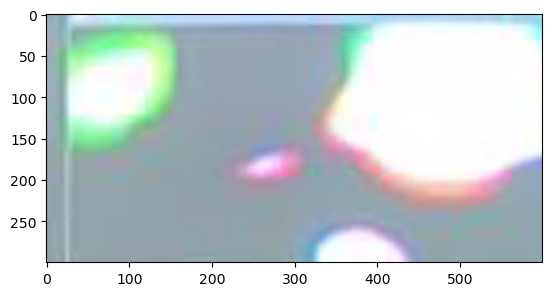

In [47]:
plt.imshow(f_test[1].detach().cpu().float().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28587574..1.2383369].


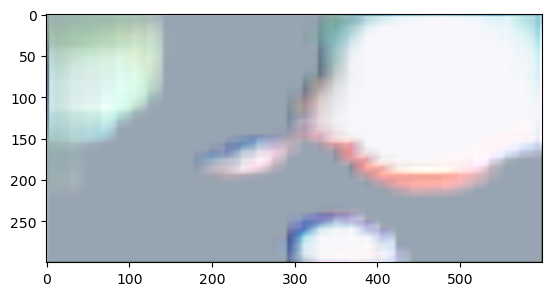

In [48]:
plt.imshow(pred_test[1].detach().cpu().float().numpy().transpose(1,2,0))

In [71]:
from diffusers import StableDiffusionPipeline
import torch

# Load stable diffusion model
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae=  pipe.vae.to(device)

def decode_latents_grad(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    with torch.amp.autocast(device):
        latents = 1 / 0.18215 * latents

        imgs = vae.decode(latents).sample

        # imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def decode_latents(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    with torch.no_grad():
        with torch.amp.autocast(device):
            latents = 1 / 0.18215 * latents

            with torch.no_grad():
                imgs = vae.decode(latents).sample

            # imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def encode_imgs(imgs):
    # imgs: [B, 3, H, W]
    with torch.no_grad():
        with torch.amp.autocast(device):
            # imgs = 2 * imgs - 1

            posterior = vae.encode(imgs).latent_dist
            latents = posterior.sample() * 0.18215

    return latents

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [63]:

import torch 
import kornia
import torchvision
H_t = torch.tensor(H).float().unsqueeze(0).cuda()
def warp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t, (orig_ref_frame.shape[0], orig_ref_frame.shape[1]))

ref_tensor = torch.tensor(orig_ref_frame.transpose(2,0,1)).float().cuda().unsqueeze(0) / 255


In [60]:
resizer =  torchvision.transforms.Resize((300, 600))

In [67]:
from utils.classfier import adv_loss_calc, resnet_predict

In [ ]:
latent = torch.randn((1,4, 4, 4), device=device)  * 5
latent.requires_grad = True

# lbfgs_latent_opt = torch.optim.LBFGS([latent], lr=1, max_iter=10)
latent_opt = torch.optim.Adam([latent], lr=100)


for i in tqdm.tqdm_notebook(range(1000)):
    # lbfgs_latent_opt.step(latent_closure_adp)
    latent_opt.zero_grad()
    d = decode_latents_grad(latent).float()

    adv_patch = resizer(d)

    adv_patch = mapper(adv_patch)

    w_mask  =warp(adv_patch*0+1)
    w  =warp(adv_patch)

    sum_tensor =  ((w_mask != 0) * -0.5 + 1) * ref_tensor + w * 0.5

    adv_loss = adv_loss_calc(sum_tensor) #+ adv_patch.norm() / 10000
    
    adv_loss.backward()

    latent_opt.step()

    if i % 10 == 0:
        # print(f"Iteration {i}, Loss: {latent_closure_adp().item():.4f}")
        print(f"Iteration {i}, Loss: {adv_loss.item():.4f}. grad_norm: {latent.grad.norm().item():.4f}")

        with torch.no_grad():
            d = decode_latents(latent).float()
            adv_patch = resizer(d)
            adv_patch_m = mapper(adv_patch)

            w_mask  =warp(adv_patch_m*0+1)
            w  =warp(adv_patch_m)

            sum_tensor =  ((w_mask != 0) * -0.5 + 1) * ref_tensor + w * 0.5
            sum_tensor = sum_tensor.cpu()

            plt.imshow(sum_tensor[0].permute(1,2,0).numpy())

            plt.show()
            print(resnet_predict(sum_tensor.cuda()))

/tmp/ipykernel_282848/940005301.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]